# Multiplexers #3: Lazy coding


## Case 1: Variables

In previous examples, we found out how omitted signal assignments inside a combinatorial logic can cause unwanted latches to be inferred. There is a variant where this does not occur and where we are allowed to be less explicit.

In [1]:
from myhdl import *
from frequently_used import up_counter

OPCODE = slice(5, 3)
MODE   = slice(3, 1)
FLAG   = 0

@block
def lazy_coding(clk, ce, reset, dout, debug):
    "Lazy-coded multiplexers"

    counter = Signal(modbv(0)[8:])
    cr = ResetSignal(0, 1, isasync = False)

    ctr = up_counter(clk, ce, cr, counter)

    @always_comb
    def worker():
        op = counter[OPCODE]
        k = counter[MODE]
        f = counter[FLAG]

        isdebug = False

        if op == 0b00:
            if ce:
                dout.next = 0xaa
            else:
                dout.next = 0xff
        elif op == 0b01:
            if k == 0:
                if f:
                    isdebug = True
                    dout.next = 0x50
                else:
                    dout.next = 0x10
            elif k == 2:
                dout.next = 0x51
            else:
                dout.next = 0x55
        elif op == 0b10:
            dout.next = 0xfa
        else: 
            dout.next = 0xff

        debug.next = isdebug

    @always_comb
    def assign():
        cr.next = reset

    return instances()

Why does this not create a combinatorial loop?
Let's have a look at the RTL graph below.

CREATE Module: 'up_counter_0'
Adding module with name: up_counter_1_1_1_8
CONVERT_RTL tree >>>>>> 'TEST_UP_COUNTER_0_WORKER' 
TRUNC: /home/pyosys/src/myhdl/myhdl-local/example/ipynb/work/myhdl-synthesis/examples/frequently_used.py:17 Implicit carry truncate: counter[8:], src[9:]
DONE instancing submodules
CREATE Module: 'test'
Adding module with name: lazy_coding_1_1_1_8_1
CONVERT_RTL tree >>>>>> 'TEST_WORKER' 
CONVERT_RTL tree >>>>>> 'TEST_ASSIGN' 
++++++++ up_counter_0: up_counter_1_1_1_8 (Module) ++++++++
DONE instancing submodules
Generating RTL image...
Display...


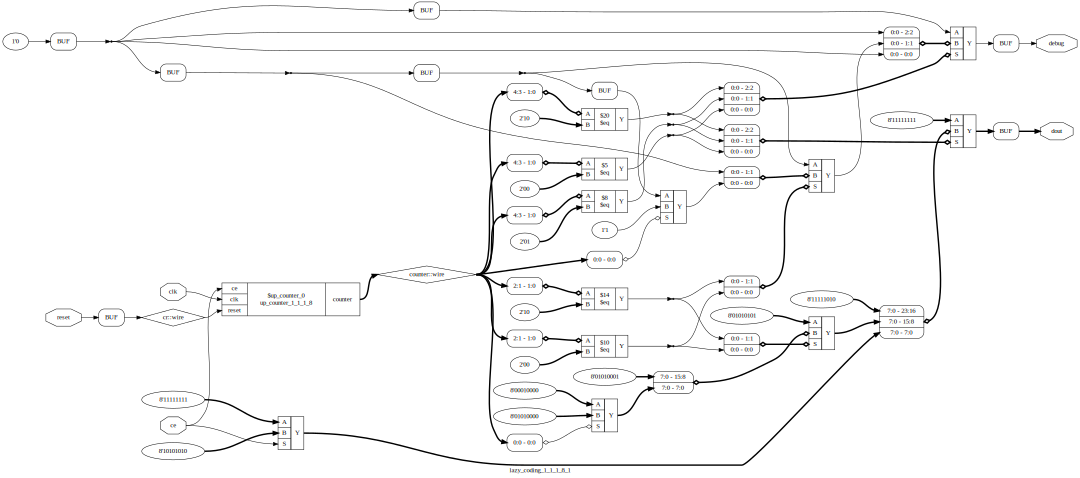

In [2]:
from ys_aux import to_svg
from myhdl.conversion import yshelper

clk, ce, debug = [ Signal(bool()) for i in range(3) ]
dout = Signal(intbv()[8:])
reset = ResetSignal(0, 1, False)

design = yshelper.Design("test")
inst = lazy_coding(clk, ce, reset, dout, debug)
inst.convert("yosys_module", design, name="test", trace=True)

display(to_svg(design, "lazy_coding_1_1_1_8_1", 150))

### Implicit defaults

The fact that a default value is specified for the variable saves us from explicitely spelling out a value assignment for each case of the multiplexed signal. Note we also must not get a `LATCH_WARNING`.

### Exercises

* Replace variable `isdebug` by using a *default* for the the `debug` signal only.

To commit your results, uncomment the following (remove '#') and run:

In [3]:
! git add mux_lazycoding.ipynb
#! git commit -m "Added multiplexer 'lazy spelling'"